# 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측
- LinearRegression 클래스는 예측값과 실제 값의 RSS를 최소화해 OLS 추정 방식으로 구현한 클래스이다. LinearRegression클래스는 fit()메서드로 X, y배열을 입력 받으면 회귀 계수(coefficients)인 W를 coef_속성에 저장한다.

In [9]:
# 선형회귀 모델
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

# boston데이터 세트 로드
boston = load_boston()

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

# boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼으로 DataFrame에 추가함.
bostonDF['PRICE'] = boston.target
print("Boston 데이터 세트의 크기:", bostonDF.shape)
bostonDF.head()


Boston 데이터 세트의 크기: (506, 14)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [13]:
# null값 없다! 
bostonDF.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
PRICE      0
dtype: int64

In [14]:
# 모두 float형이다!
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


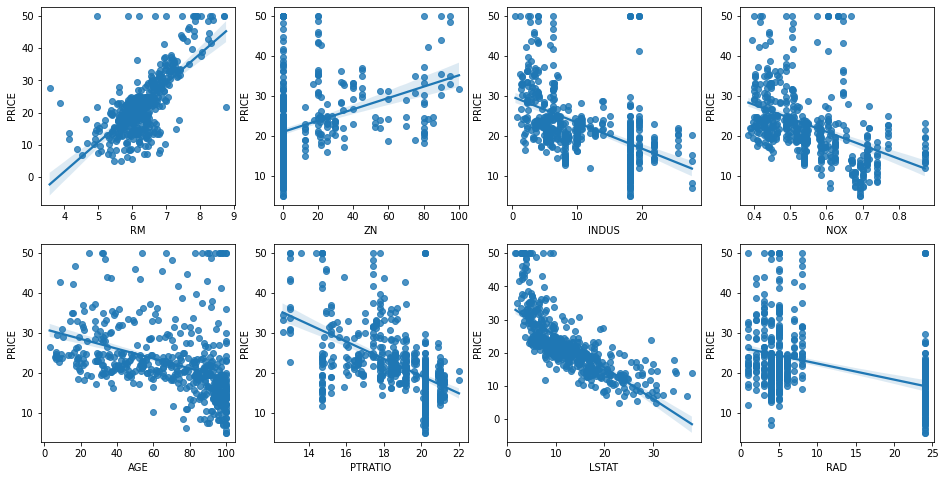

In [19]:
# 각 칼럼이 회귀 결과에 미치는 영향이 어느 정도인지 시각화해보겠다.
# 8개의 칼럼에 대해 값이 증가할수록 PRICE값이 어떻게 변하는지 확인한다.

# 2개의 행과 4개의 열을 가진 subplots이용, axs는 4*2개의 ax를가짐
fig, axs = plt.subplots(figsize = (16, 8), ncols=4, nrows = 2)
lm_features = ['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']
for i, feature in enumerate(lm_features):
  row = int(i/4)
  col = i % 4

  # seaborn의 regplot을 이용해 산점도와 선형회귀 직선을 함께 표현
  sns.regplot(x = feature, y = 'PRICE', data = bostonDF, ax = axs[row][col])

  # 해석: RM과 LSTAT이 PRICE와 영향도가 가장 크다. RM(방 개수)는 
  # 양 방향의 선형성이 크다. 방의 크기가 증가하면 가격도 증가한다.
  # LSTAT은 음 방향의 선형성이 가장 크다. 

In [21]:
# 이제 LinearRegression 클래스를 이용해 보스턴 주택 가격의 회귀 모델을 만들겠다. 
# train_test_split()을 이용해 학습과 테스트 데이터 세트를 분리해 학습과 예측을 수행
# metrics 모듈의 mean_squared_error()와 r2_score() API를 이용해 MSE와 R2 Score를 측정하겠다.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
x_data = bostonDF.drop(['PRICE'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(x_data, y_target, test_size = 0.3, random_state = 156)

# 선형회귀 OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print("MSE : {0:.3f}, RMSE : {1:.3f}".format(mse, rmse))
print('Variance score: {0:.3}'.format(r2_score(y_test, y_preds)))

MSE : 17.297, RMSE : 4.159
Variance score: 0.757


In [22]:
# LinearRegression으로 생성한 주택가격 모델의 intercept(절편)과 coefficients(회귀 계수) 값을 보겠다
# 절편은 intercept_, 회귀 계수는 coef_속성에 저장됨
print('절편 값:', lr.intercept_)
print('회귀 계수 값:', np.round(lr.coef_, 1))

절편 값: 40.995595172164755
회귀 계수 값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [25]:
# coef_ 속성은 회귀 계수 값만 가지고 있어서 이를 피처별 회귀 계수값으로 다시 매핑하고, 내림차순 정렬하겠다.

coeff = pd.Series(data = np.round(lr.coef_, 1), index = x_data.columns)
coeff.sort_values(ascending = False)

# 해석: RM이 양의 값으로 회귀 계수가 가장 크며, NOX 피처의 회귀 계수 - 값이 너무 커보인다.

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [27]:
# 이번에는 5개의 폴드 세트에서 cross_val_score()를 이용해 교차검증으로 MSE와 RMSE를 측정해 보겠다.

from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis = 1, inplace = False)
lr = LinearRegression()

# cross_val_score()로 5 폴드 세트로 MSE를 구한뒤 이를 기반으로 다시 RMSE구함
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring = 'neg_mean_squared_error', cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring = 'neg_mean_squared_error')로 반환된 값은 모두 음수 따라서 -1을 곱해준거지
print(' 5 folds의 개별 Negative MSE scores:', np.round(neg_mse_scores, 2))
print(' 5 folds의 개별 RMSE score :', np.round(rmse_scores, 2))
print(' 5 folds의 평균 RMSE : {0:.3f}'.format(avg_rmse))

 5 folds의 개별 Negative MSE scores: [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds의 개별 RMSE score : [3.53 5.1  5.75 8.99 5.77]
 5 folds의 평균 RMSE : 5.829


# 다항 회귀와 과대적합/ 과소적합 이해

## 다항 회귀 이해

In [29]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# 다항식으로 변환한 단항식 생성, [[0,1], [2,3]]의 2x2 행렬 생성
X = np.arange(4).reshape(2,2)
print('일차 단항식 계수 피처:\n', X)

# degree = 2인 2차 다항식으로 변환하기 위해 PolynomialFeatures를 이용해 변환
poly = PolynomialFeatures(degree = 2)
poly.fit(X)
poly_ftr = poly.transform(X)
print('변환된 2차 다항식 계수 피처:\n', poly_ftr)

일차 단항식 계수 피처:
 [[0 1]
 [2 3]]
변환된 2차 다항식 계수 피처:
 [[1. 0. 1. 0. 0. 1.]
 [1. 2. 3. 4. 6. 9.]]


In [32]:
def polynomial_func(X):
    y = 1 + 2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3
    print(X[:, 0])
    print(X[:, 1])
    return y

X = np.arange(0,4).reshape(2,2)

print('일차 단항식 계수 feature: \n' ,X)
y = polynomial_func(X)
print('삼차 다항식 결정값: \n', y)

일차 단항식 계수 feature: 
 [[0 1]
 [2 3]]
[0 2]
[1 3]
삼차 다항식 결정값: 
 [  5 125]


In [33]:
# 3차 다항식 변환
poly_ftr = PolynomialFeatures(degree = 3).fit_transform(X)
print('3차 다항식 계수 feature: \n', poly_ftr)

# Linear Regression에 3차 다항식 계수 feature와 3차 다항식 결정값으로 학습 후 회귀 계수 확인
model = LinearRegression()
model.fit(poly_ftr, y)
print('Polynomial 회귀 계수:\n', np.round(model.coef_,2))
print('Polynomial 회귀 shape :\n', model.coef_.shape)

3차 다항식 계수 feature: 
 [[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]
Polynomial 회귀 계수:
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]
Polynomial 회귀 shape :
 (10,)


In [35]:
# 위에 코드를 한방에 할수 있는 Pipeline객체 이용
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np

def polynomial_func(X):
    y = 1 + 2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3
    return y
  
# pipelines 객체로 Streamline하게 Polynomial feature 변환과 linear regression을 연결
model = Pipeline([('poly', PolynomialFeatures(degree = 3)),
                  ('linear', LinearRegression())])

X = np.arange(4).reshape(2,2)
y = polynomial_func(X)

model = model.fit(X, y)

print("Polynomial 회귀 계수\n", np.round(model.named_steps['linear'].coef_,2))

Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]
